In [4]:
import math
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import os
import os.path
import pickle
from PIL import Image, ImageDraw
import face_recognition
from face_recognition.face_recognition_cli import image_files_in_folder
import time
import numpy as np 
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

#Adding allowed extention for photos
ALLOWED_EXTENSIONS = {'txt'}

## Test model

In [5]:
X = []
y = []

train_dir = "./faces/train"
encode_dir = "./faces/encode"
all_encodings_paths = []
i = 0
for class_dir in os.listdir(train_dir):
    if not os.path.isdir(os.path.join(train_dir, class_dir)):
        continue

    for encoding_path in image_files_in_folder(os.path.join(encode_dir, class_dir)):
        if os.path.splitext(encoding_path)[1][1:] not in ALLOWED_EXTENSIONS:
            continue

        all_encodings_paths.append(encoding_path)
        file = open(encoding_path, "r") 
        d = encoding_path.split("/")[-2]
        dx = np.array(file.read().split(",")).astype(np.float64)
        X.append(dx)
        y.append(d)
        file.close()
        i += 1
    
    if i > 3000:
        break

print(len(all_encodings_paths))

3002


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

k: 1, Train/Test Score: 1.000/0.965
k: 3, Train/Test Score: 1.000/0.961
k: 5, Train/Test Score: 1.000/0.967
k: 7, Train/Test Score: 1.000/0.961
k: 9, Train/Test Score: 1.000/0.956
k: 11, Train/Test Score: 1.000/0.956
k: 13, Train/Test Score: 1.000/0.951
k: 15, Train/Test Score: 1.000/0.951
k: 17, Train/Test Score: 1.000/0.947
k: 19, Train/Test Score: 1.000/0.948


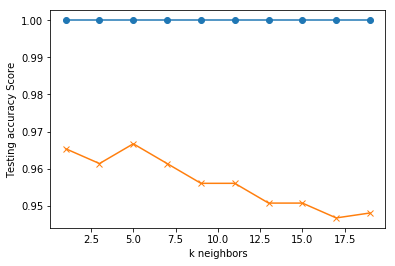

In [7]:
# Loop through different k values to see which has the highest accuracy
# Note: We only use odd numbers because we don't want any ties
train_scores = []
test_scores = []
for k in range(1, 20, 2):
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='ball_tree', weights='distance')
    knn.fit(X_train, y_train)
    train_score = knn.score(X_train, y_train)
    test_score = knn.score(X_test, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train/Test Score: {train_score:.3f}/{test_score:.3f}")


    
plt.plot(range(1, 20, 2), train_scores, marker='o')
plt.plot(range(1, 20, 2), test_scores, marker="x")
plt.xlabel("k neighbors")
plt.ylabel("Testing accuracy Score")
plt.show()

## Real model

In [8]:
#Setting train model method
#Trains a k-nearest neighbors classifier for face recognition
def train(train_dir="./faces/encode", model_save_path=None, n_neighbors=None, knn_algo='ball_tree', verbose=True):
    X = []
    y = []

    all_encodings_paths = []
    for class_dir in os.listdir(train_dir):
        if not os.path.isdir(os.path.join(train_dir, class_dir)):
            continue

        for encoding_path in image_files_in_folder(os.path.join(encode_dir, class_dir)):
            if os.path.splitext(encoding_path)[1][1:] not in ALLOWED_EXTENSIONS:
                continue

            all_encodings_paths.append(encoding_path)
            file = open(encoding_path, "r") 
            d = encoding_path.split("/")[-2]
            dx = np.array(file.read().split(",")).astype(np.float64)
            X.append(dx)
            y.append(d)
            file.close()

    print(len(all_encodings_paths))

    # Create and train the KNN classifier
    knn_clf = KNeighborsClassifier(n_neighbors=n_neighbors, algorithm=knn_algo, weights='distance')
    knn_clf.fit(X, y)

    # Save the trained KNN classifier
    if model_save_path is not None:
        with open(model_save_path, 'wb') as f:
            pickle.dump(knn_clf, f)

    return knn_clf

In [9]:
if __name__ == "__main__":
    print("Training KNN classifier...")
    classifier = train("./faces/encode", model_save_path="trained_knn_model.clf", n_neighbors=5)
    print("Training complete!")

Training KNN classifier...
196694
Training complete!
